In [1]:
import pandas as pd

df = pd.read_csv('movies_with_genres.csv')

keep_columns = [
    'Title', 'Year', 'Revenue (Millions)', 'Similar_Movies'
]

df_clean = df[keep_columns].copy()

In [2]:
df_clean['Similar_Movies'] = df_clean['Similar_Movies'].apply(eval)

similar_pairs = []
for idx, row in df_clean.iterrows():
    for similar_title in row['Similar_Movies']:
        similar_pairs.append({
            'Title_1': row['Title'],
            'Title_2': similar_title,
            'Year_1': row['Year'],
            'Year_2': df_clean[df_clean['Title'] == similar_title]['Year'].values[0],
            'Revenue_1': row['Revenue (Millions)'],
            'Revenue_2': df_clean[df_clean['Title'] == similar_title]['Revenue (Millions)'].values[0],
            'Group': 'A'  
        })

df_similar = pd.DataFrame(similar_pairs)

In [3]:
import random

dissimilar_pairs = []
titles = df_clean['Title'].tolist()

for _ in range(len(df_similar)): 
    title1, title2 = random.sample(titles, 2)
    dissimilar_pairs.append({
        'Title_1': title1,
        'Title_2': title2,
        'Year_1': df_clean[df_clean['Title'] == title1]['Year'].values[0],
        'Year_2': df_clean[df_clean['Title'] == title2]['Year'].values[0],
        'Revenue_1': df_clean[df_clean['Title'] == title1]['Revenue (Millions)'].values[0],
        'Revenue_2': df_clean[df_clean['Title'] == title2]['Revenue (Millions)'].values[0],
        'Group': 'B'  
    })

df_dissimilar = pd.DataFrame(dissimilar_pairs)

In [4]:
df_pairs = pd.concat([df_similar, df_dissimilar], ignore_index=True)

In [5]:
df_pairs['Year_Diff'] = abs(df_pairs['Year_1'] - df_pairs['Year_2'])
df_pairs = df_pairs[df_pairs['Year_Diff'] <= 2]  

In [6]:
df_pairs['Revenue_Diff'] = abs(df_pairs['Revenue_1'] - df_pairs['Revenue_2'])

In [7]:
df_pairs

,Title_1,Title_2,Year_1,Year_2,Revenue_1,Revenue_2,Group,Year_Diff,Revenue_Diff
0,Guardians of the Galaxy,Suicide Squad,2014,2016,333.13,325.02,A,2,8.11
1,Guardians of the Galaxy,Interstellar,2014,2014,333.13,187.99,A,0,145.14
2,Guardians of the Galaxy,Star Wars: Episode VII - The Force Awakens,2014,2015,333.13,936.63,A,1,603.50
4,Guardians of the Galaxy,Hardcore Henry,2014,2015,333.13,9.24,A,1,323.89
5,Guardians of the Galaxy,Battleship,2014,2012,333.13,65.17,A,2,267.96
...,...,...,...,...,...,...,...,...,...
6846,Trainwreck,War Dogs,2015,2016,110.01,43.02,B,1,66.99
6849,Lowriders,The Babadook,2016,2014,4.21,0.92,B,2,3.29
6852,The Lone Ranger,Bridge of Spies,2013,2015,89.29,72.31,B,2,16.98
6860,Brimstone,Solace,2016,2015,NaN,NaN,B,1,NaN


In [8]:
import pandas as pd
from scipy import stats

group_A = df_pairs[df_pairs['Group'] == 'A']['Revenue_Diff']
group_B = df_pairs[df_pairs['Group'] == 'B']['Revenue_Diff']

In [15]:
group_A_clean = group_A.dropna()
group_B_clean = group_B.dropna()

print("Cleaned Group A size:", len(group_A_clean))  
print("Cleaned Group B size:", len(group_B_clean))  

Cleaned Group A size: 1242
Cleaned Group B size: 1100


In [16]:
_, p_A = stats.shapiro(group_A)
_, p_B = stats.shapiro(group_B)

print(f"Group A normality p-value: {p_A:.4f}")
print(f"Group B normality p-value: {p_B:.4f}")


Group A normality p-value: 1.0000
Group B normality p-value: 1.0000


In [18]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_A_clean, group_B_clean, equal_var=True)

print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Similar movies have significantly different revenue differences.")
else:
    print("Fail to reject H₀: No significant revenue difference between groups.")

T-statistic: -3.1489, P-value: 0.0017
Reject H₀: Similar movies have significantly different revenue differences.


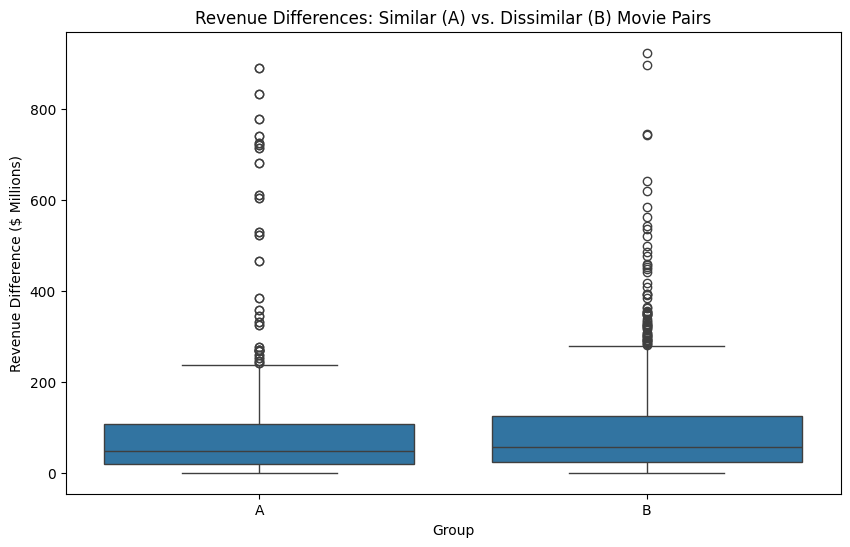

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Revenue_Diff', data=df_pairs.dropna())
plt.title("Revenue Differences: Similar (A) vs. Dissimilar (B) Movie Pairs")
plt.ylabel("Revenue Difference ($ Millions)")
plt.show()